# Project Phase 1: Video Dialog 

## Imports

In [ ]:
import json
from pprint import pprint

#Open Search
from opensearchpy import OpenSearch

#Embeddings neighborhood
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import pickle
import spacy

#Contextual embeddings and self-attention
import numpy as np
from sklearn.decomposition import PCA
from transformers import AutoConfig, AutoModelForSequenceClassification
from bertviz import model_view, head_view

# Get the interactive Tools for Matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

## 2.2 Text-based Search

### Load the video captions

In [3]:
def load_captions_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    processed = {}
    for video_id, captions in data.items():
        processed[video_id] = {
            "segments": captions['segments'] if 'segments' in captions else captions,
        }
    return processed

# Load the data
val_data1 = load_captions_data('captions/val_1.json')
val_data2 = load_captions_data('captions/val_2.json')

# Combine dictionaries (preserving video_id as keys)
all_captions_data = {**val_data1, **val_data2}

pprint(f"Number of captions: {len(all_captions_data)}")
pprint(f"Example Captions: {all_captions_data}")

'Number of captions: 4917'
("Example Captions: {'v_uqiMw7tQ1Cc': {'segments': {'duration': 55.15, "
 "'timestamps': [[0, 4.14], [4.14, 33.36], [33.36, 55.15]], 'sentences': ['Two "
 'men both dressed in athletic gear are standing and talking in an indoor '
 "weight lifting gym filled with other equipment.', ' One man is holding onto "
 'a rope attached to a machine, and the other man instructs him to bend down '
 'on his left knee while still holding onto the rope and he showing the man '
 'how to have proper form.\', " The man then instructs the man holding the '
 'rope to pull the row down a few times and he\'s talking the whole time."]}}, '
 "'v_bXdq2zI1Ms0': {'segments': {'duration': 73.1, 'timestamps': [[6.94, "
 "69.08], [37.28, 43.49], [43.13, 55.55]], 'sentences': ['Three men are "
 "standing on a mat.', ' The man in front begins to do karate on the mat.', ' "
 "He gets down on the ground and flips around.']}}, 'v_FsS_NCZEfaI': "
 "{'segments': {'duration': 212.74, 'timestamps'

### Load the videos

In [4]:
with open('activity_net.v1-3.min.json', 'r') as json_data:
    data = json.load(json_data)

database = {}

for video_id in data['database']:
    database["v_" + video_id] = data['database'][video_id]

# Create the list with all data, sorted by the number of annotations
sorted_database = sorted(
    database.items(),
    key=lambda x: len(x[1]['annotations']),
    reverse=True
)

# Top 10 videos in number of annotations
top_videos = dict(sorted_database[:27])

pprint(top_videos)

{'v_-ap649M020k': {'annotations': [{'label': 'Longboarding',
                                    'segment': [9.965381472401754,
                                                10.961919619641929]},
                                   {'label': 'Longboarding',
                                    'segment': [15.280251591016023,
                                                32.88575885892579]},
                                   {'label': 'Longboarding',
                                    'segment': [37.86844959512666,
                                                44.84421662580789]},
                                   {'label': 'Longboarding',
                                    'segment': [54.80959809820965,
                                                60.456647599237314]},
                                   {'label': 'Longboarding',
                                    'segment': [72.7472847485328,
                                                74.07600227818637]},
             

In [ ]:
matching_ids = set(database.keys()) & set(all_captions_data.keys())
print(f"Número de IDs correspondentes: {len(matching_ids)}")
print(f"IDs no top_videos: {list(top_videos.keys())[:5]}...")
print(f"IDs em all_captions_data: {list(all_captions_data.keys())[:5]}...")

Número de IDs correspondentes: 4917
IDs no top_videos: ['v_o1WPnnvs00I', 'v_oGwn4NUeoy8', 'v_VEDRmPt_-Ms', 'v_qF3EbR8y8go', 'v_DLJqhYP-C0k']...
IDs em all_captions_data: ['v_uqiMw7tQ1Cc', 'v_bXdq2zI1Ms0', 'v_FsS_NCZEfaI', 'v_K6Tm5xHkJ5c', 'v_4Lu8ECLHvK4']...


### Compute the final captions dataset

In [ ]:
final_dataset_captions = {}


#Check and store the captions' of the top 10 videos
for video_id in top_videos:
    try:
        if (all_captions_data[video_id] != None):
            final_dataset_captions[video_id] = all_captions_data[video_id]
    except Exception as e:
        None

final_dataset_captions.pop("v_PJ72Yl0B1rY", None) # This video has no available URL

pprint(final_dataset_captions)
pprint(len(final_dataset_captions))

{'v_2ji02dSx1nM': {'segments': {'duration': 162.69,
                                'sentences': ['A surfer is riding on a surf '
                                              'board in the ocean.',
                                              ' He goes through the waves as '
                                              'they crash around him.',
                                              ' He continues riding the waves '
                                              'and talking to the camera in an '
                                              'interview.'],
                                'timestamps': [[0, 9.76],
                                               [18.71, 68.33],
                                               [82.97, 162.69]]}},
 'v_6gyD-Mte2ZM': {'segments': {'duration': 188.25,
                                'sentences': ["There's a man in a brown shirt "
                                              'bowling in a large alley in a '
                             

### OpenSearch connection settings

In [ ]:
#Connections to the Open Search Server
host = 'api.novasearch.org'
port = 443

user = 'user09'
password = 'grupo09fct'
index_name = user

Test if OpenSearch is up and running

In [8]:
# Create the client with SSL/TLS enabled, but hostname verification disabled.
client = OpenSearch(
    hosts = [{'host': host, 'port': port}],
    http_compress = True, # enables gzip compression for request bodies
    http_auth = (user, password),
    use_ssl = True,
    url_prefix = 'opensearch_v2',
    verify_certs = False,
    ssl_assert_hostname = False,
    ssl_show_warn = False
)

if client.indices.exists(index_name):

    resp = client.indices.open(index = index_name)
    print(resp)

    print('\n----------------------------------------------------------------------------------- INDEX SETTINGS')
    settings = client.indices.get_settings(index = index_name)
    pprint(settings)

    print('\n----------------------------------------------------------------------------------- INDEX MAPPINGS')
    mappings = client.indices.get_mapping(index = index_name)
    pprint(mappings)

    print('\n----------------------------------------------------------------------------------- INDEX #DOCs')
    print(client.count(index = index_name))
else:
    print("Index does not exist.")

{'acknowledged': True, 'shards_acknowledged': True}

----------------------------------------------------------------------------------- INDEX SETTINGS
{'user09': {'settings': {'index': {'creation_date': '1744801011344',
                                   'knn': 'true',
                                   'number_of_replicas': '0',
                                   'number_of_shards': '4',
                                   'provided_name': 'user09',
                                   'refresh_interval': '-1',
                                   'replication': {'type': 'DOCUMENT'},
                                   'uuid': 'E4wZ-s3OS3e6qGKM0f9Lbw',
                                   'version': {'created': '136387927'}}}}}

----------------------------------------------------------------------------------- INDEX MAPPINGS
{'user09': {'mappings': {'dynamic': 'strict',
                         'properties': {'description': {'type': 'text'},
                                        'sentence

In [ ]:
client.indices.delete(index=index_name, ignore=[400, 404])

{'acknowledged': True}

### Create the index mappings for video captions

In [10]:
index_body = {
    "settings": {
        "index": {
            "number_of_replicas": 0,
            "number_of_shards": 4,
            "refresh_interval": "-1",
            "knn": "true"
        },
    },
    "mappings": {
        "dynamic": "strict",
        "properties": {
            #video_id
            "title": {
                "type": "keyword"
            },
            #sentences
            "description": {
                "type": "text"
            },
        }
    }
}

if client.indices.exists(index=index_name):
    print("Index already exists.")
else:        
    response = client.indices.create(index_name, body=index_body)
    print('\nCreating index...')
    print(response)


Creating index...
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'user09'}


Index the dataset

In [11]:
for video_id, data in final_dataset_captions.items():
    print(f"Title: {video_id}")
    print(f"Description: {data['segments']['sentences']}")

for video_id, data in final_dataset_captions.items():
    filtered_caption = {
        "title": video_id,
        "description": data['segments']['sentences']
    }
    
    resp = client.index(index=index_name, id=video_id, body=filtered_caption)
    print(resp['result'])

Title: v_t6f_O8a4sSg
Description: ['An introduction comes onto the screen for a video about skate boarding tricks.', ' Several tricks are shown while someone narrates the tricks.', ' A man is shown on the screen giving details about the tricks and offering pointers and tips.', ' The video ends with the closing captions shown on the screen.']
Title: v_6gyD-Mte2ZM
Description: ["There's a man in a brown shirt bowling in a large alley in a competition with spectators watching him.", ' He begins by picking up his blue bowling ball and then, holds it firmly to shoot it at the pins.', ' He gets a strike after the ball hits the pin.', ' He continues throwing the ball several times and every time he gets a strike.', ' Then when he hits the ball again, he knocks down four pins in the first attempt.', ' Then after he continues bowling, the pins knock down the remaining pins down.', ' He bowls again and knocks down four pins.', ' On the second attempt, he knocks down more pins and finally gets a 

### Search Functionality

Text-based Search 

In [12]:
client.indices.refresh(index=index_name)

{'_shards': {'total': 4, 'successful': 4, 'failed': 0}}

In [13]:
client.count(index = index_name)

{'count': 10,
 '_shards': {'total': 4, 'successful': 4, 'skipped': 0, 'failed': 0}}

In [14]:
# Search for a specific caption

qtxt = "finally gets a spare."

text_query = {
  "size": 5,
  "_source": ['title', 'description'],
  "query": {
    "multi_match": {
      "query": qtxt,
      "fields": ['description'],
    }
  }
}

response = client.search(
    body=text_query,
    index=index_name
)

print("\nSearch results:")
pprint(response)


Search results:
{'_shards': {'failed': 0, 'skipped': 0, 'successful': 4, 'total': 4},
 'hits': {'hits': [{'_id': 'v_6gyD-Mte2ZM',
                    '_index': 'user09',
                    '_score': 2.848579,
                    '_source': {'description': ["There's a man in a brown "
                                                'shirt bowling in a large '
                                                'alley in a competition with '
                                                'spectators watching him.',
                                                ' He begins by picking up his '
                                                'blue bowling ball and then, '
                                                'holds it firmly to shoot it '
                                                'at the pins.',
                                                ' He gets a strike after the '
                                                'ball hits the pin.',
                               

Term-level Search

In [15]:
# Search for a specific video ID

term_query = {
    "size": 5,
    "_source": ["title", "description"],
    "query": {
        "term": {
            "title": "v_od9EdcDcByA"
        }
    }
}

response = client.search(
    body=term_query,
    index=index_name
)

print("\nSearch results:")
pprint(response)


Search results:
{'_shards': {'failed': 0, 'skipped': 0, 'successful': 4, 'total': 4},
 'hits': {'hits': [{'_id': 'v_od9EdcDcByA',
                    '_index': 'user09',
                    '_score': 0.9808291,
                    '_source': {'description': ['A shot of balls are shown as '
                                                'well as clips of people '
                                                'surfing and walking around.',
                                                ' More people are seen playing '
                                                'paintball as others speak to '
                                                'one another as well as surf.',
                                                ' The video continues on with '
                                                'several shots of people '
                                                'playing paintball that '
                                                'transitions into people '
         

Boolean Search

In [16]:
# Search for a video containing the words "skate" and "tricks"

bool_query = {
    "size": 5,
    "_source": ["title", "description"],
    "query": {
        "bool": {
            "must": [
                {"match": {"description": "skate"}},  # Must contain "skate"
                {"match": {"description": "tricks"}}  # Must contain "tricks"
            ],
        }
    }
}

response = client.search(
    body=bool_query,
    index=index_name
)

print("\nSearch results:")
pprint(response)


Search results:
{'_shards': {'failed': 0, 'skipped': 0, 'successful': 4, 'total': 4},
 'hits': {'hits': [{'_id': 'v_t6f_O8a4sSg',
                    '_index': 'user09',
                    '_score': 2.43581,
                    '_source': {'description': ['An introduction comes onto '
                                                'the screen for a video about '
                                                'skate boarding tricks.',
                                                ' Several tricks are shown '
                                                'while someone narrates the '
                                                'tricks.',
                                                ' A man is shown on the screen '
                                                'giving details about the '
                                                'tricks and offering pointers '
                                                'and tips.',
                                              

## 2.3 Embeddings Neighborhood

In [17]:
client.indices.delete(index=index_name, ignore=[400, 404])

{'acknowledged': True}

 ### Index mappings to support k-nn vectors

In [18]:
index_body = {
    "settings": {
        "index": {
            "number_of_replicas": 0,
            "number_of_shards": 4,
            "refresh_interval": "-1",
            "knn": True
        }
    },
    "mappings": {
        "dynamic": "strict",
        "properties": {
            "title": { "type": "keyword" },
            "description": { "type": "text" },
            "sentence_embedding": {
                "type": "knn_vector",
                "dimension": 768,
                "method": {
                    "name": "hnsw",
                    "space_type": "innerproduct",
                    "engine": "faiss",
                    "parameters": {
                        "ef_construction": 256,
                        "m": 48
                    }
                }
            }
        }
    }
}


if client.indices.exists(index=index_name):
    print("Index already existed. You may force the new mappings.")
else:        
    response = client.indices.create(index_name, body=index_body)
    print('\nCreating index:')
    print(response)


Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'user09'}


In [19]:
client.indices.refresh(index=index_name)

{'_shards': {'total': 4, 'successful': 4, 'failed': 0}}

In [20]:
client.count(index = index_name)

{'count': 0,
 '_shards': {'total': 4, 'successful': 4, 'skipped': 0, 'failed': 0}}

### Dual-Encoders

In [ ]:
# Model and Tokenizer utilized for the enconding and creation of the embeddings
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2")
model = AutoModel.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2")

In [22]:
#Mean Pooling - Take average of all tokens
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


#Encode text
def encode(texts):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    return embeddings

Compute the video text embeddings

In [ ]:
all_embeddings = {}

for video_id, data in final_dataset_captions.items():
    # Join all sentences to one paragraph-like string
    full_description = " ".join(data['segments']['sentences'])
    
    embedding = encode(full_description)
    
    all_embeddings[video_id] = {
        "title": video_id,
        "description": data['segments']['sentences'],
        "sentence_embedding": embedding[0].numpy()
    }
        
    resp = client.index(index=index_name, id=video_id, body=all_embeddings[video_id])
    print(resp['result'])

    stored = client.get(index=index_name, id=video_id)
    print("\nIndexed Document:")
    pprint(stored["_source"])
    print("-" * 50)

# Save the data to the pickle file
with open('all_embeddings.pkl', 'wb') as f:
    pickle.dump(all_embeddings, f)

created

Indexed Document:
{'description': ['An introduction comes onto the screen for a video about '
                 'skate boarding tricks.',
                 ' Several tricks are shown while someone narrates the tricks.',
                 ' A man is shown on the screen giving details about the '
                 'tricks and offering pointers and tips.',
                 ' The video ends with the closing captions shown on the '
                 'screen.'],
 'sentence_embedding': [-0.014382562600076199,
                        -0.022280169650912285,
                        0.021698258817195892,
                        0.020328203216195107,
                        0.0432252399623394,
                        -0.0013239150866866112,
                        0.03738516941666603,
                        0.023351825773715973,
                        -0.048520397394895554,
                        0.05206630378961563,
                        -0.017785951495170593,
                        -0.

### Load the data from the pickle file

In [ ]:
with open('all_embeddings.pkl', 'rb') as f:
    all_embeddings = pickle.load(f)
print(all_embeddings)


{'v_t6f_O8a4sSg': {'title': 'v_t6f_O8a4sSg', 'description': ['An introduction comes onto the screen for a video about skate boarding tricks.', ' Several tricks are shown while someone narrates the tricks.', ' A man is shown on the screen giving details about the tricks and offering pointers and tips.', ' The video ends with the closing captions shown on the screen.'], 'sentence_embedding': array([-1.43825626e-02, -2.22801697e-02,  2.16982588e-02,  2.03282032e-02,
        4.32252400e-02, -1.32391509e-03,  3.73851694e-02,  2.33518258e-02,
       -4.85203974e-02,  5.20663038e-02, -1.77859515e-02, -6.54118583e-02,
       -1.01971682e-02,  5.02217608e-03,  5.37653044e-02, -5.93207777e-02,
        9.30966530e-03, -6.42847791e-02,  1.76998898e-02, -2.22318508e-02,
       -2.50885300e-02,  3.66076976e-02,  1.70764960e-02, -3.97567376e-02,
       -2.65968833e-02,  8.71487148e-03, -1.09048719e-02, -2.95894705e-02,
       -3.33008566e-03,  1.38160344e-02, -8.39219335e-03, -9.30576026e-03,
       

### Search query for embedding index

In [25]:
client.indices.refresh(index=index_name)

{'_shards': {'total': 4, 'successful': 4, 'failed': 0}}

In [ ]:
# Search for a specific caption using KNN
query = "finally gets a spare."
query_emb = encode(query)

query_denc = {
  'size': 5,
  '_source': ['title', 'description'],
   "query": {
        "knn": {
          "sentence_embedding": {
            "vector": query_emb[0].numpy(),
            "k": 2
          }
        }
      }
}

response = client.search(
    body = query_denc,
    index = index_name
)

print('\nSearch results:')
pprint(response)


Search results:
{'_shards': {'failed': 0, 'skipped': 0, 'successful': 4, 'total': 4},
 'hits': {'hits': [{'_id': 'v_6gyD-Mte2ZM',
                    '_index': 'user09',
                    '_score': 1.1583455,
                    '_source': {'description': ["There's a man in a brown "
                                                'shirt bowling in a large '
                                                'alley in a competition with '
                                                'spectators watching him.',
                                                ' He begins by picking up his '
                                                'blue bowling ball and then, '
                                                'holds it firmly to shoot it '
                                                'at the pins.',
                                                ' He gets a strike after the '
                                                'ball hits the pin.',
                              

## 2.4 Constrained Embedding Searches

In [ ]:
# Embedding of a query and search in the index using that encoded string 
nlp = spacy.load("en_core_web_sm")
query = "show me moments of a man surfing."
query_embedding = encode(query)[0].numpy().tolist()

def get_nouns_verbs(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if token.pos_ in {"NOUN", "VERB"}])

filter_terms = get_nouns_verbs(query)
print(f"Filter terms: {filter_terms}")

search_body = {
    'size': 100,
    "query": {
        "bool": {
            "must": [{
                "knn": {
                    "sentence_embedding": {
                        "vector": query_embedding,
                        "k": 1
                    }
                }
            }],
            "filter": [{
                "match": {
                    "description": {
                        "query": filter_terms,
                        "operator": "or"
                    }
                }
            }]
        }
    },
    "_source": ["title", "description"]
}

response = client.search(index=index_name, body=search_body)
print(f"Total documents found: {response['hits']['total']['value']}")

for hit in response["hits"]["hits"]:
    print(f"Title: {hit['_source']['title']}")
    print("Relevant sentences:")
    for sentence in hit['_source']['description']:
        if "surf" in sentence.lower():
            print(f"  → {sentence}")
        else:
            print(f"  - {sentence}")


Filter terms: show moments man surfing
Total documents found: 6
Title: v_od9EdcDcByA
Relevant sentences:
  → A shot of balls are shown as well as clips of people surfing and walking around.
  →  More people are seen playing paintball as others speak to one another as well as surf.
  -  The video continues on with several shots of people playing paintball that transitions into people skateboarding and walking around.
Title: v_QHn9KyE-zZo
Relevant sentences:
  - A person is seen close up walking on a rope and jumping.
  -  A man speaks to the camera while showing more clips of people walking on a rope.
  -  The men tighten the rope and show more people walking and juggling.
  -  Many people speak to the camera as the people continue to walk and perform tricks on the rope.
Title: v_t6f_O8a4sSg
Relevant sentences:
  - An introduction comes onto the screen for a video about skate boarding tricks.
  -  Several tricks are shown while someone narrates the tricks.
  -  A man is shown on the scr

In [ ]:
query = "bokling"  # Intentional typo for "bowling"

search_body = {
    "query": {
        "match": {
            "description": {
                "query": query,
                "fuzziness": "AUTO",  # Automatically corrects "bokling" to "bowling"
                "operator": "or"
            }
        }
    }
}

response = client.search(index=index_name, body=search_body)
print(f"Total documents found: {response['hits']['total']['value']}")

for hit in response["hits"]["hits"]:
    print(f"Title: {hit['_source']['title']}")
    print("Full description:")
    for sentence in hit['_source']['description']:
        print(f"  - {sentence}")


Total documents found: 1
Title: v_6gyD-Mte2ZM
Full description:
  - There's a man in a brown shirt bowling in a large alley in a competition with spectators watching him.
  -  He begins by picking up his blue bowling ball and then, holds it firmly to shoot it at the pins.
  -  He gets a strike after the ball hits the pin.
  -  He continues throwing the ball several times and every time he gets a strike.
  -  Then when he hits the ball again, he knocks down four pins in the first attempt.
  -  Then after he continues bowling, the pins knock down the remaining pins down.
  -  He bowls again and knocks down four pins.
  -  On the second attempt, he knocks down more pins and finally gets a spare.
  -  The crowd cheers for him as he bowls the ball again knocking down two more pins.
  -  He raises his hands feeling victorious.


## 2.5 Contextual embeddings and Self-attention

### Contextual embeddings

In [29]:
sentence = "He raises his hands feeling victorious."

In [76]:
# Load a pre-trained BERT model fine-tuned on MS MARCO for relevance ranking
model_path = 'nboost/pt-bert-base-uncased-msmarco'

# Initialize tokenizer and model with specific configurations
tokenizer = AutoTokenizer.from_pretrained(model_path)  # Converts text to token IDs
config = AutoConfig.from_pretrained(
    model_path,
    output_hidden_states=True,  # Returns all hidden states for analysis
    output_attentions=True      # Returns attention weights for interpretability
)
model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    config=config  # Load model with the specified configuration
)

# Tokenize input sentence with proper formatting for BERT
inputs = tokenizer(
    sentence,
    return_tensors='pt',         # Returns PyTorch tensors
    add_special_tokens=True,     # Adds [CLS] and [SEP] tokens
    max_length=512,              # Truncates to BERT's max length
    padding=True,                # Pads sequences to max length
    truncation=True              # Truncates longer sequences
)

# Convert token IDs back to tokens for interpretability
input_ids = inputs["input_ids"][0]
input_tokens_list = tokenizer.convert_ids_to_tokens(input_ids)

# Run model inference without gradient calculation (faster, less memory)
with torch.no_grad():
    outputs = model(**inputs)  # Returns logits, hidden_states, attentions

Hidden layer embedding

In [77]:
# The format is as follow:
# outputs['hidden_states'][layer_m][0][token_n]
layer_m = 12
token_n = 1

# Get all the embeddings of one layer:
output_embeddings = outputs['hidden_states'][layer_m][0]
output_embeddings.shape

hidden_states = outputs.hidden_states

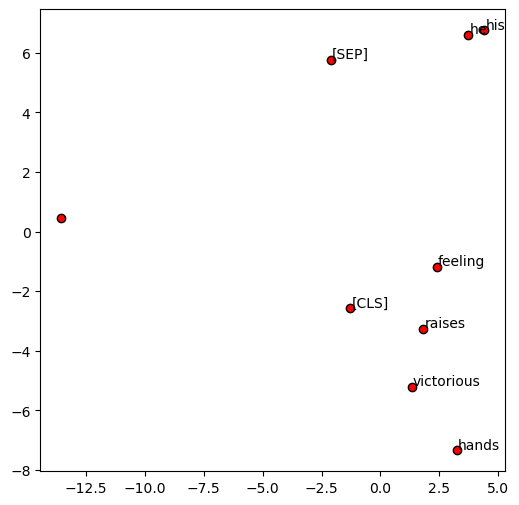

In [78]:
def display_scatterplot(data, words):

    if data.shape[1] == 2:
        twodim = data
    else:
        pca = PCA()
        pca.fit(output_embeddings.detach().numpy())
        twodim = pca.transform(data)[:,:2]
    
    plt.style.use('default') # https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

    return

display_scatterplot(output_embeddings.detach().numpy(), input_tokens_list)

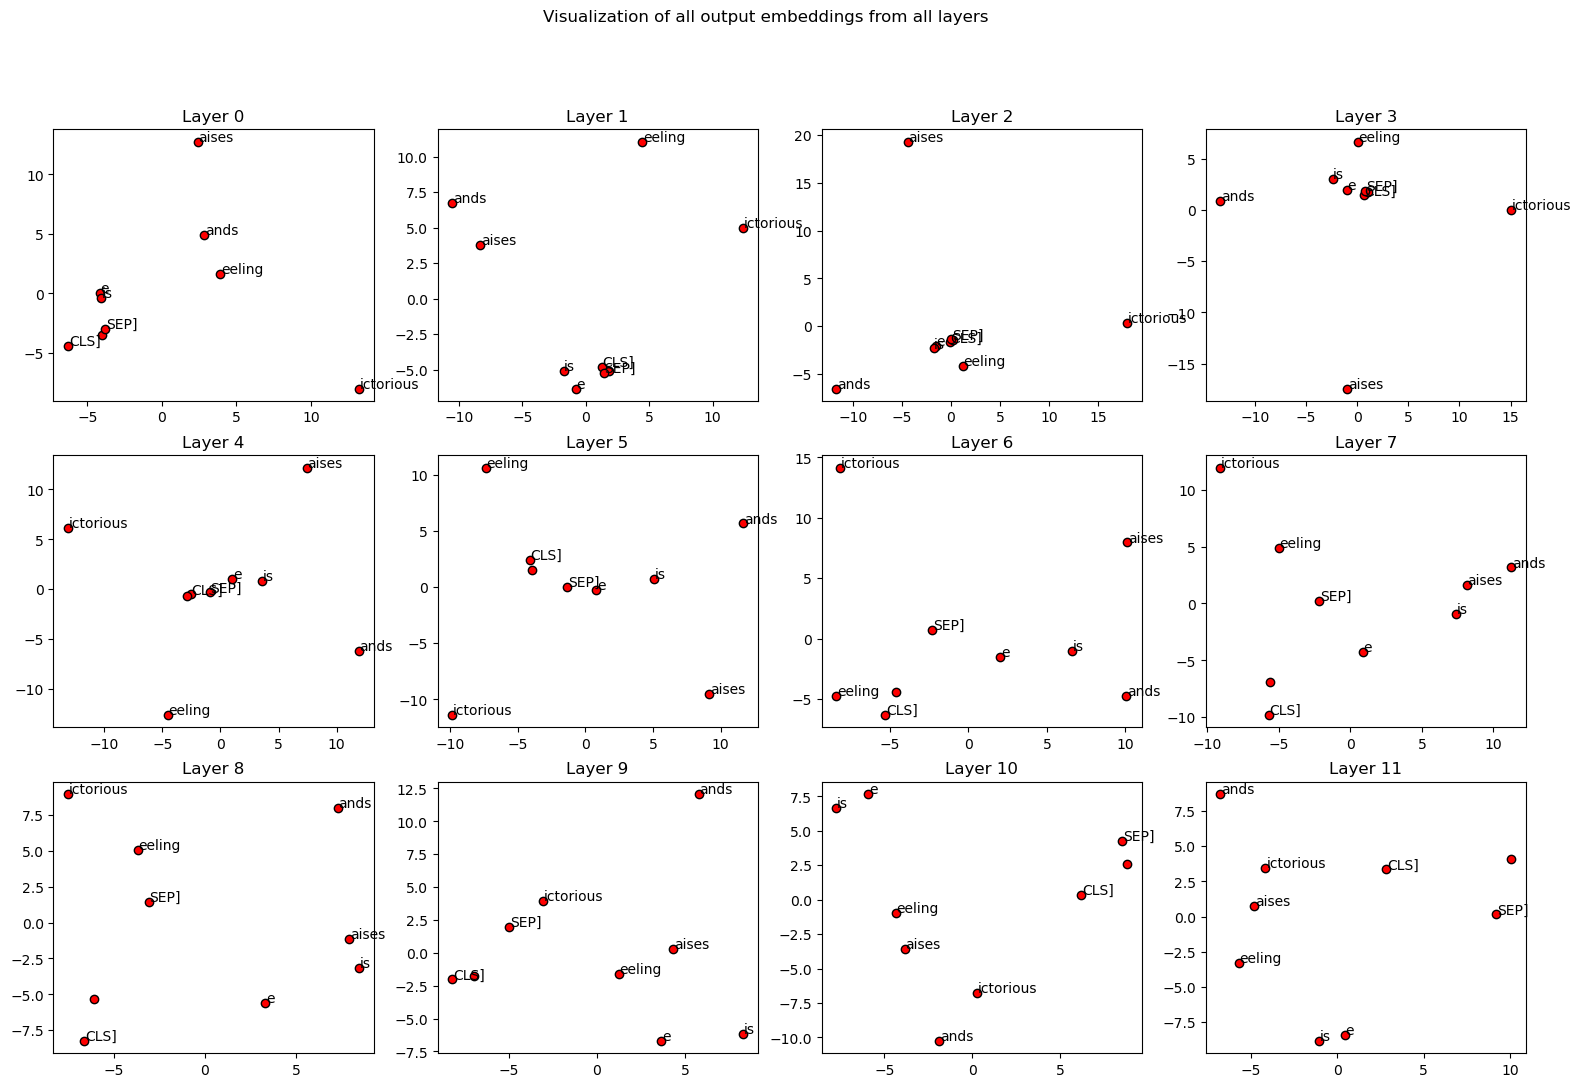

In [ ]:
rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*4)
fig.set_figwidth(cols*4+3)
plt.rcParams.update({'font.size': 6})


layer = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        plt.rcParams.update({'font.size': 10})
        current_hidden_state = hidden_states[layer][0].detach().numpy()
        
        if current_hidden_state.shape[1] == 2:
            twodim = current_hidden_state
        else:
            twodim = PCA().fit_transform(current_hidden_state)[:,:2]

        plt.style.use('default') # https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
        im = ax.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
        for word, (x,y) in zip(input_tokens_list, twodim):
            ax.text(x+0.05, y+0.05, word[1:])
        
        # Show all ticks and label them with the respective list entries
        ax.set_title("Layer " + str(layer))
            
        # Loop over data dimensions and create text annotations.
        layer = layer + 1

fig.suptitle("Visualization of all output embeddings from all layers")
plt.show()

### Positional embeddings

In [79]:
sentence1 = "hello hello hello hello hello hello hello hello hello hello hello hello hello hello hello hello hello hello hello hello"
sentence2 = "bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye bye"

In [83]:
model_path = 'nboost/pt-bert-base-uncased-msmarco'

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config)

inputs = tokenizer(sentence1, sentence2, return_tensors='pt', add_special_tokens=True, max_length=512, padding=True, truncation=True)
input_ids = inputs["input_ids"][0]
input_tokens_list = tokenizer.convert_ids_to_tokens(input_ids)
with torch.no_grad():
    outputs = model(**inputs)

In [84]:
# The format is as follow:
# outputs['hidden_states'][layer_m][0][token_n]
layer_m = 12
token_n = 1
# Get all the embeddings of one layer:
output_embeddings = outputs['hidden_states'][layer_m][0]
output_embeddings.shape

hidden_states = outputs.hidden_states

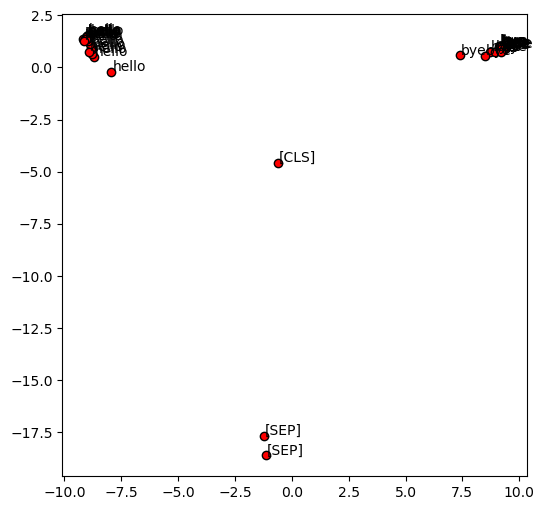

In [85]:
def display_scatterplot(data, words):

    if data.shape[1] == 2:
        twodim = data
    else:
        pca = PCA()
        pca.fit(output_embeddings.detach().numpy())
        twodim = pca.transform(data)[:,:2]
    
    plt.style.use('default') # https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

    return

display_scatterplot(output_embeddings.detach().numpy(), input_tokens_list)

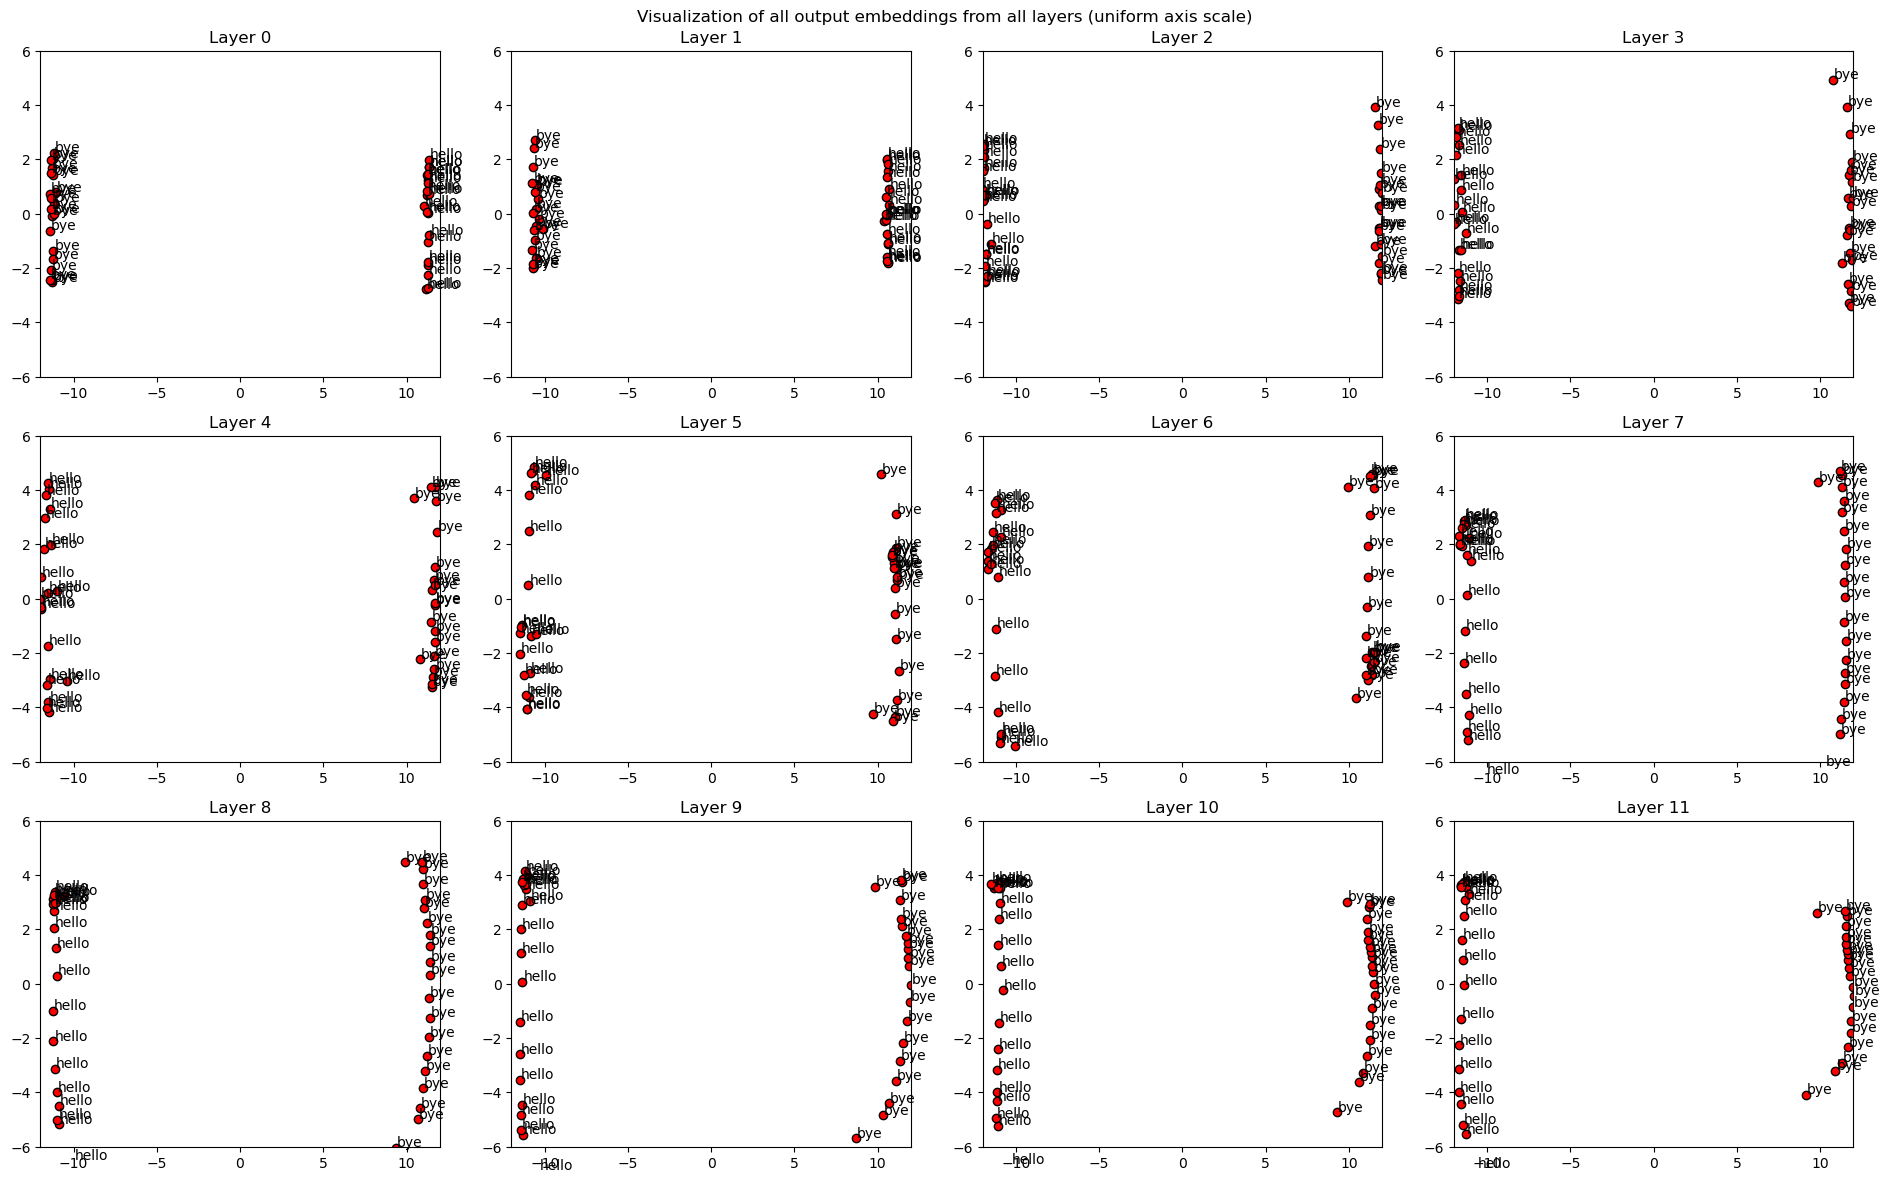

In [38]:
layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*4)
fig.set_figwidth(cols*4+3)
plt.rcParams.update({'font.size': 6})

# Define your axis scale ranges
x_range = (-12, 12)
y_range = (-6, 6)

layer = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r, c]
        plt.rcParams.update({'font.size': 10})

        current_hidden_state = hidden_states[layer][0].detach().numpy()

        # Filter out [CLS] and [SEP]
        tokens_filtered = []
        vectors_filtered = []
        for i, token in enumerate(input_tokens_list):
            if token not in ['[CLS]', '[SEP]']:
                tokens_filtered.append(token)
                vectors_filtered.append(current_hidden_state[i])

        vectors_filtered = np.array(vectors_filtered)

        # Apply PCA if necessary
        if vectors_filtered.shape[1] == 2:
            twodim = vectors_filtered
        else:
            twodim = PCA().fit_transform(vectors_filtered)[:, :2]

        plt.style.use('default')
        ax.scatter(twodim[:, 0], twodim[:, 1], edgecolors='k', c='r')

        for word, (x, y) in zip(tokens_filtered, twodim):
            ax.text(x + 0.05, y + 0.05, word)

        # Set title and fixed axes
        ax.set_title("Layer " + str(layer))
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)

        layer += 1

fig.suptitle("Visualization of all output embeddings from all layers (uniform axis scale)")
plt.tight_layout()
plt.show()




### Self-attention

Cross-encoder

In [87]:
sentence = "He raises his hands feeling victorious."
question = "What did he raise?"

In [88]:
model_path = 'nboost/pt-bert-base-uncased-msmarco'

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained(model_path, config=config)

inputs = tokenizer(sentence, question, return_tensors='pt', add_special_tokens=True, max_length=512, padding=True, truncation=True)
input_ids = inputs["input_ids"][0]
tokens = tokenizer.convert_ids_to_tokens(input_ids)

with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions

Visualization of all the attention heads in one layer

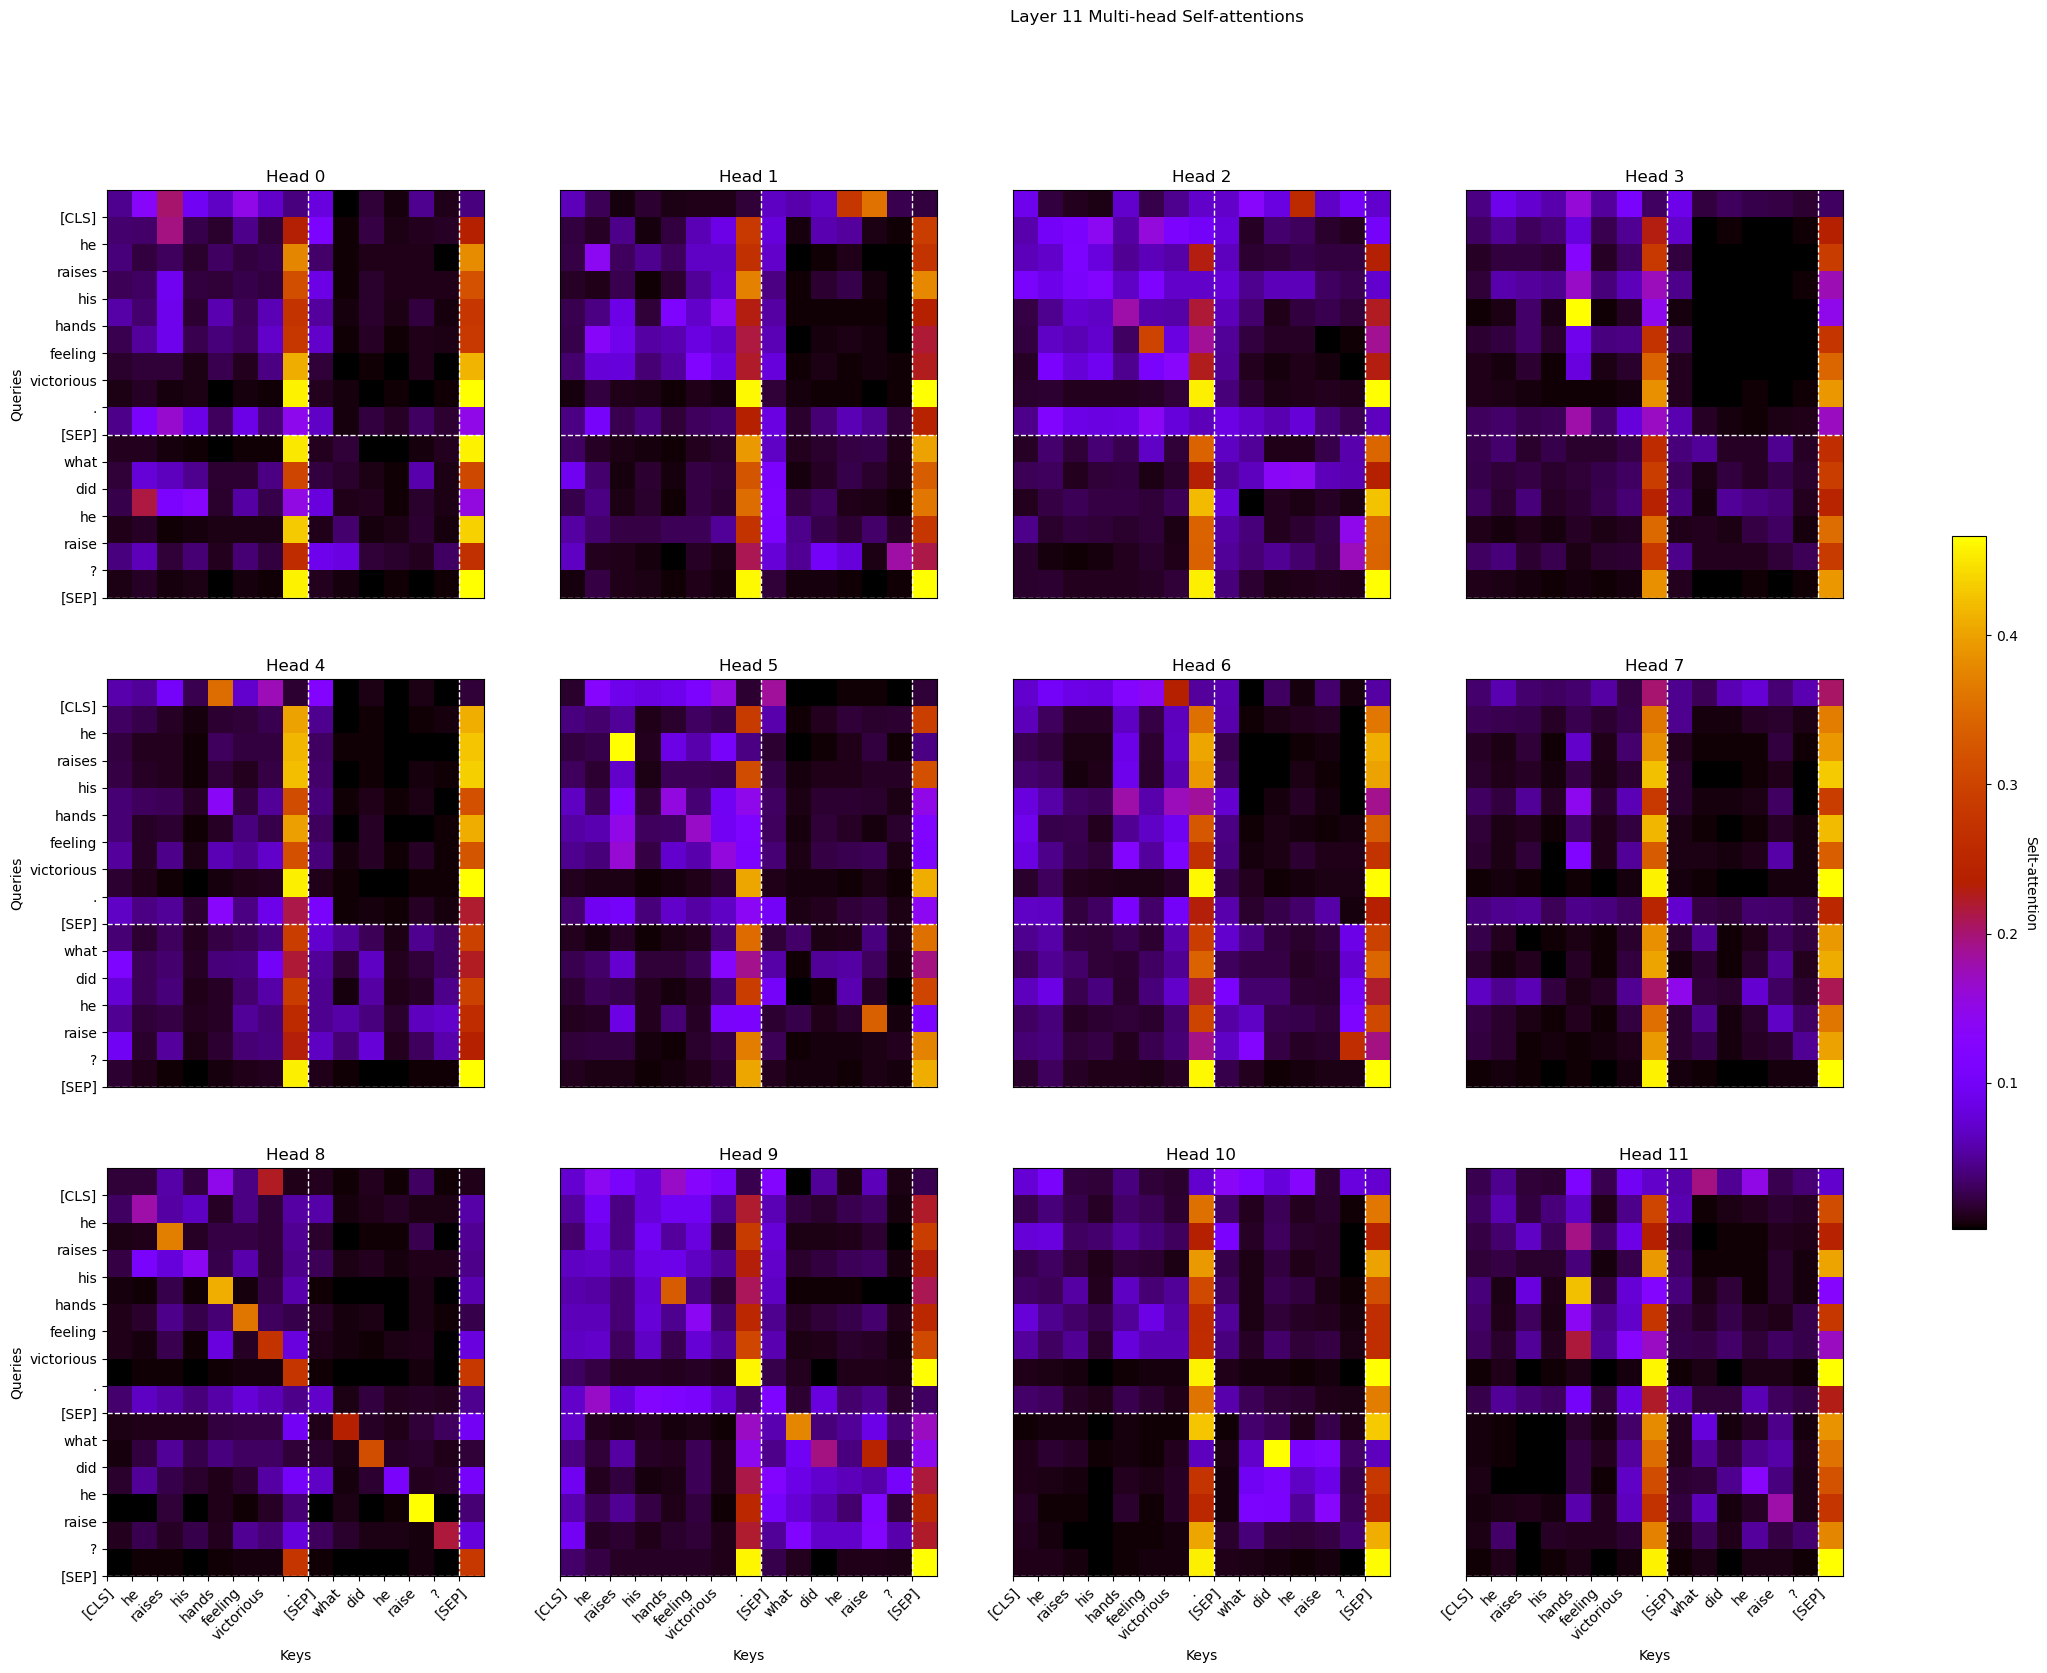

In [89]:
sep_indices = [i for i, token in enumerate(tokens) if token == '[SEP]']

layer = 11

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*6)
fig.set_figwidth(cols*6+4)
plt.rcParams.update({'font.size': 10})

j = 0
for r in range(rows):
    for c in range(cols):
        ax = ax_full[r, c]

        sattention = attentions[layer][0][j].numpy()
        sattention = np.flip(sattention, 0)  # flip vertically to match y-axis

        im = ax.pcolormesh(sattention, cmap='gnuplot')

        ax.set_title(f"Head {j}")
        ax.set_yticks(np.arange(len(tokens)))
        if c == 0:
            ax.set_yticklabels(reversed(tokens))
            ax.set_ylabel("Queries")
        else:
            ax.set_yticks([])

        ax.set_xticks(np.arange(len(tokens)))
        if r == rows - 1:
            ax.set_xticklabels(tokens)
            ax.set_xlabel("Keys")
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        else:
            ax.set_xticks([])

        # Add vertical and horizontal lines at [SEP] positions
        for sep in sep_indices:
            # Since we flipped the matrix vertically, y index needs to be (len - sep - 1)
            ax.axvline(sep, color='white', linestyle='--', linewidth=1)
            ax.axhline(len(tokens) - sep - 1, color='white', linestyle='--', linewidth=1)

        j += 1

fig.suptitle("Layer " + str(layer) + " Multi-head Self-attentions")
cbar = fig.colorbar(im, ax=ax_full, location='right', shrink=0.5)
cbar.ax.set_ylabel("Selt-attention", rotation=-90, va="bottom")
plt.show()

#### Dual-encoder

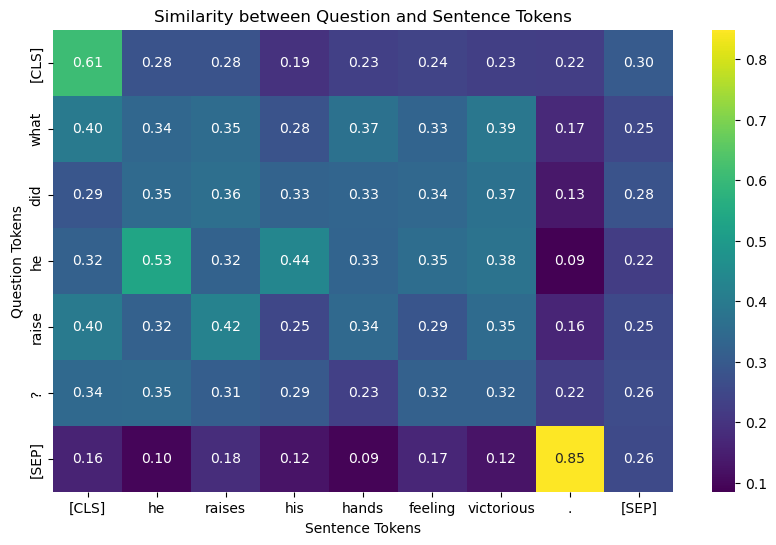

In [ ]:
# We use Cross-Encoder two times, one for each sentence, and then we compare the similarities between the words
inputs_a = tokenizer(question, return_tensors="pt")
inputs_b = tokenizer(sentence, return_tensors="pt")

with torch.no_grad():
    output_a = model(**inputs_a).last_hidden_state.squeeze(0)
    output_b = model(**inputs_b).last_hidden_state.squeeze(0) 

output_a_norm = torch.nn.functional.normalize(output_a, p=2, dim=1)
output_b_norm = torch.nn.functional.normalize(output_b, p=2, dim=1)

similarity_matrix = torch.matmul(output_a_norm, output_b_norm.T)  # (seq_len_a, seq_len_b)

tokens_a = tokenizer.convert_ids_to_tokens(inputs_a["input_ids"][0])
tokens_b = tokenizer.convert_ids_to_tokens(inputs_b["input_ids"][0])

plt.figure(figsize=(10, 6))
sns.heatmap(similarity_matrix.numpy(), xticklabels=tokens_b, yticklabels=tokens_a, cmap="viridis", annot=True, fmt=".2f")
plt.xlabel("Sentence Tokens")
plt.ylabel("Question Tokens")
plt.title("Similarity between Question and Sentence Tokens")
plt.show()

### Interpretability

In [44]:
layer = 11  # analyze the final layer
attentions = outputs.attentions  # shape: (num_layers, batch, num_heads, seq_len, seq_len)

# Get shape info
num_layers = len(attentions)
seq_len = attentions[0].shape[-1]

# Store total attention received for each token across all heads, per layer
attention_received = torch.zeros((num_layers, seq_len))

# Loop through each layer
for l in range(num_layers):
    attn = attentions[l][0]  # shape: (num_heads, seq_len, seq_len)
    attn_sum = attn.sum(dim=0)  # sum over query dimension → shape: (seq_len, seq_len)
    attention_received[l] = attn_sum.sum(dim=0)  # sum over key dimension


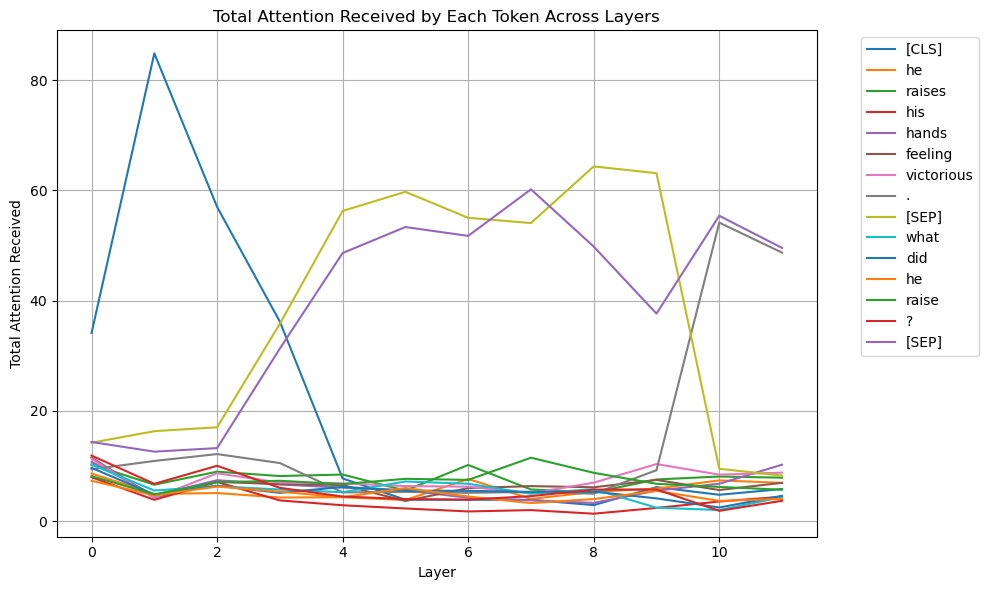

In [45]:
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

plt.figure(figsize=(10, 6))
for token_idx in range(seq_len):
    plt.plot(range(num_layers), attention_received[:, token_idx], label=tokens[token_idx])

plt.title("Total Attention Received by Each Token Across Layers")
plt.xlabel("Layer")
plt.ylabel("Total Attention Received")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()